# Creating an algorithm

In this notebook, we are going to explain how to implement a new optimization algorithm using the metaheuristic-designer framework.

For this example, we are going to implement a basic evolutionary strategy.

In [1]:
import random
import metaheuristic_designer as mhd
from metaheuristic_designer import GeneralAlgorithm
from metaheuristic_designer.selectionMethods import SurvivorSelection, ParentSelection
from metaheuristic_designer.operators import OperatorReal
from metaheuristic_designer.initializers import UniformVectorInitializer
from metaheuristic_designer.benchmarks import Sphere

For simplicity, we will assume we are working with real coded vectors.

We will also predefine the operators, but in real situations it might be wiser to let the user specify the user they want to use.

To configure our evolution strategy, we will need to specify the number of parents and offpring in each generation.
The operator will be a gaussian mutation, it will have a standard deviation associated which will be another parameter.

To create the algorithm, we will make a class that inherits from ```SearchStrategy``` and will implement its methods.

In this case we will implement the ```select_parents``` method that chooses the individuals to be chosen for mutation, the ```perturb``` method that will perform a mutation on the selected indivuals, the ```select_individuals``` that will choose the individuals that will remain for the next generation.

Here, we will make extensive use of already implemented components, like ```ParentSelection```, ```SurvivorSelection```, ```Operator```, but you can provide your own implementation of those, which will be explained in different notebooks.

The ```SearchStrategy``` class has some attributes that must be used for the 
algorithm to work correctly.

The algorithm will have a ```name```, if unspecified, a default name will be chosen. This is the name of the algorithm showed in logs.

A population initialization module ```pop_init``` must be present to perform the initialization of the algorithm (an explanation will be present in its respective notebook). It will also specify the size of the initialized population.

The algorithm has a list of individuals called ```population``` which holds. It is a standard python list with variable size.

We also have a ```best``` attribute that holds the best individual in each generation.

You can optionally store the parameters of the algorithm in a dictionary or an instance of ```ParamScheduler``` in the attribute ```params```. It is recomended to use the latter because it allows parameters to change over time. We will not worry about this in this example.

All of these attributes are generated on the ```__init__``` method of the ```SearchStrategy``` class.

In [2]:
# ES search strategy class
class BasicES(mhd.SearchStrategy):
    # Class constructor
    def __init__(self, pop_init, parent_size, offspring_size, sigma):
        self.parent_size = parent_size
        self.offspring_size = offspring_size

        # Create the mutation operator for use later
        self.mutate_op = OperatorReal(
            "MutRand", {"method": "Gauss", "F": sigma, "N": 1}
        )

        # Force pop_init to agree with the population size, this is not mandatory.
        pop_init.pop_size = parent_size

        # Create the parent selection module, select the best half of the parents
        self.parent_sel_op = ParentSelection("Best", {"amount": parent_size // 2})

        # Create the parent selection module, select the best half of the parents
        self.surv_sel_op = SurvivorSelection("keepbest", {"amount": parent_size})

        super().__init__(pop_init, name="Basic ES")

    # This method receives the population from the previous generation
    # and some extra information (that we don't need here) and returns
    # a list of selected individuals.
    def select_parents(self, population, **kwargs):
        return self.parent_sel_op(population)

    # This method receives the parents that we are going to mutate,
    # the objective function class and some extra information that we
    # are not going to use.
    def perturb(self, parent_list, objfunc, **kwargs):
        offspring = []

        # Iterate until the list of individuals has the
        # size we want.
        while len(offspring) < self.offspring_size:
            # Choose an individual from the parent list.
            indiv = random.choice(parent_list)

            # Apply the operator.
            new_indiv = self.mutate_op(
                indiv, parent_list, objfunc, self.best, self.pop_init
            )

            # Repair the solution to keep the vector within the bounds
            # of the problem.
            new_indiv.genotype = objfunc.repair_solution(new_indiv.genotype)

            # Add the individual to the offspring list.
            offspring.append(new_indiv)

        # Update the best solution
        current_best = max(offspring, key=lambda x: x.fitness)
        if self.best.fitness < current_best.fitness:
            self.best = current_best

        return offspring

    # This method selects the individuals that will be chosen for the next
    # generation, it gets the original population along with the newly
    # generated individuals.
    def select_individuals(self, prev_population, offspring, **kwargs):
        return self.surv_sel_op(prev_population, offspring)

To begin with the optimization we need one more component, the ```Algorithm```. This is mostly the same for all algorithms, so it is recomended that you use the already implemented ```GeneralAlgorithm``` class for this purpose unless you REALLY need something different. If this is the case, you have an ```Algorithm``` base class available that you can inherit from.

We will be using one of the benchmark functions already implemented in this framework that consist on adding the square of the vector components.

In [3]:
# Define the parameters of the optimization process
params = {"stop_cond": "time_limit", "time_limit": 100.0, "verbose": True, "v_timer": 2}

# Define the parameters of the algorithm
n_parents = 50
n_offspring = 250

# Define the objective function
objfunc = Sphere(3)

# Define a population initialization module
pop_init = UniformVectorInitializer(
    objfunc.vecsize, objfunc.low_lim, objfunc.up_lim, pop_size=n_parents
)

# Instanciate the newly created algorithm
algorithm = BasicES(pop_init, n_parents, n_offspring, 1e-3)

# Define a Search method
search = GeneralAlgorithm(objfunc, algorithm, params)

# Optimize the objective function
best_solution, best_fitness = search.optimize()

Initializing optimization of Sphere function using Basic ES
-----------------------------------------------------------

Optimizing Sphere function using Basic ES:
	Real time Spent: 0.0 s
	CPU time Spent:  0.0 s
	Generation: 0
	Best fitness: 216.04589161959848
	Evaluations of fitness: 50

Optimizing Sphere function using Basic ES:
	Real time Spent: 2.0 s
	CPU time Spent:  2.0 s
	Generation: 488
	Best fitness: 198.45718277887545
	Evaluations of fitness: 122050

Optimizing Sphere function using Basic ES:
	Real time Spent: 4.0 s
	CPU time Spent:  4.0 s
	Generation: 981
	Best fitness: 181.32343270028673
	Evaluations of fitness: 245300

Optimizing Sphere function using Basic ES:
	Real time Spent: 6.0 s
	CPU time Spent:  6.0 s
	Generation: 1471
	Best fitness: 164.98316815473146
	Evaluations of fitness: 367800

Optimizing Sphere function using Basic ES:
	Real time Spent: 8.0 s
	CPU time Spent:  8.0 s
	Generation: 1962
	Best fitness: 149.40630698384481
	Evaluations of fitness: 490550

Optimizi

Best solution: [-1.02680397e-09  1.47654867e-09 -1.15148037e-09]
Solution fitness: 4.560429407606584e-18

Number of generations: 24449
Real time spent: 100.0022s
CPU time spent: 99.92299s
Number of fitness evaluations: 6112300
Best fitness: 4.560429407606584e-18


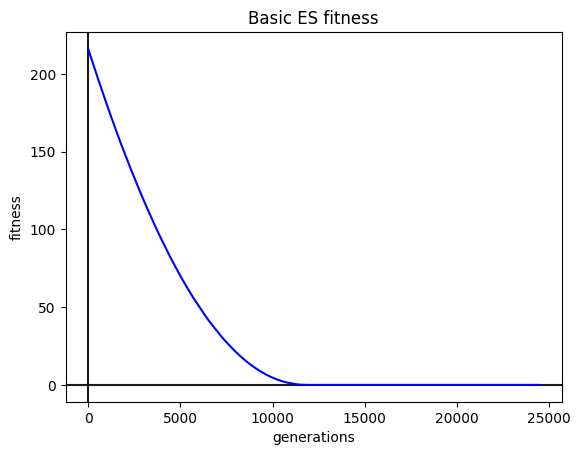

In [4]:
print(f"Best solution: {best_solution}")
print(f"Solution fitness: {best_fitness}\n")
search.display_report()